# Advertising Investment Analysis for Profit Maximization
Advertising is a widely used technique to promote products to potential customers. However, it demands a significant financial investment, so the methodology used must guarantee that profits exceed this cost. Therefore, it is important to study how the distribution of the budget invested in various advertising channels affects the return on investment, in order to design an effective strategy that maximizes profits while reducing potential losses.

This project examines the public dataset [Advertising-Dataset](https://www.kaggle.com/datasets/ashydv/advertising-dataset), which includes 200 entries detailing the daily budget allocation across three advertising channels (TV, Radio, and Newspaper) and the resulting sales revenue for that day.

The objectives of this proyect are:
- Evaluate the performance of each advertising channel.
- Identify optimal budget allocation strategies.
- Provide data-driven recommendations.

The content of the project is divided as follows:
1. Exploratory Data Analysis (EDA)
2. Model design and validation
3. Experiments with differente strategies
4. Conclussions


## 1. Exploratory Data Analysis (EDA)
First, we start by loading the necessary libraries and reading the dataset. It is worth mentioning that the invested budget on each advertising channel are in units of $1000.00, while the reported sales in units of $1M.

In [2]:
# libraries requiered
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf # for SQL queries

# data reading
data = pd.read_csv('Advertising.csv').drop(['Index'], axis=1)
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


The sales column is transformed to match with the units of the investment on each advertising channel

In [3]:
data['Sales'] = data['Sales']*1000
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22100.0
1,44.5,39.3,45.1,10400.0
2,17.2,45.9,69.3,9300.0
3,151.5,41.3,58.5,18500.0
4,180.8,10.8,58.4,12900.0


Subsequently, it is verified that there are no missing values.

In [4]:
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

A Total column is calculated, considering the total amount of investment in all advertising channels:

In [5]:
total_frame = sqldf('''
    SELECT TV, Radio, Newspaper, TV+Radio+Newspaper as Total, Sales FROM data
''')
total_frame.head()

,TV,Radio,Newspaper,Total,Sales
0,230.1,37.8,69.2,337.1,22100.0
1,44.5,39.3,45.1,128.9,10400.0
2,17.2,45.9,69.3,132.4,9300.0
3,151.5,41.3,58.5,251.3,18500.0
4,180.8,10.8,58.4,250.0,12900.0


The average investment in each advertising channel and the resulting average revenue are analyzed. Note that the average investment ($200,860) in advertising is lower than the sales revenue ($14,022,500). Additionally, assuming a profit margin of 25% on sales, the average profit is around $3,505,625, which is still greater than the amount spent on advertising. However, we can enhance our analysis to suggest a more effective strategy that requires a lower investment on advertising while generating higher profits.

In [6]:
mean_frame = sqldf('''
    SELECT AVG(TV) TV, AVG(Radio) Radio, AVG(Newspaper) Newspaper, AVG(Total) Total, AVG(Sales) Sales
    FROM total_frame''')
mean_frame

,TV,Radio,Newspaper,Total,Sales
0,147.0425,23.264,30.554,200.8605,14022.5


The following graph shows the average distribution of the budget between the three advertising channels, highlighting that most of the investment is made on the TV channel.

C:\Users\limal\AppData\Local\Temp\ipykernel_18128\3870426277.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


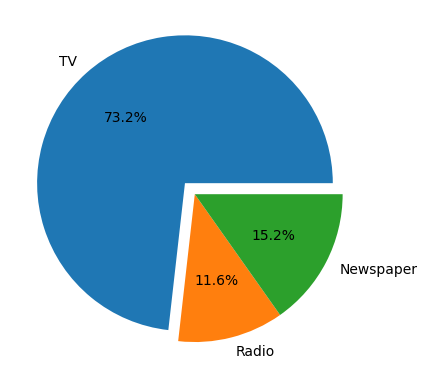

In [7]:
# grafico de la distribucion de la inversion promedio
fig, axs = plt.subplots(1,1)
explode = (0.1, 0, 0)
axs.pie(mean_frame.values[0][0:3], explode=explode, labels=['TV', 'Radio', 'Newspaper'], autopct='%1.1f%%')
fig.show()

The effect on sales due to investment in each advertising channel is studied. The following graphs illustrate the predicted linear relationship considering the individual effect on each advertising channel and the total investment. 

As for the individual analysis, TV and Radio channels show a clear linear dependence between the invested budget and the resulting sales, while the newspaper channel does not show a clear trend.

On the other hand, the total investment shows a clear linear trend, indicating that the greater the budget invested, the greater the sales.

C:\Users\limal\AppData\Local\Temp\ipykernel_18128\1452933936.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


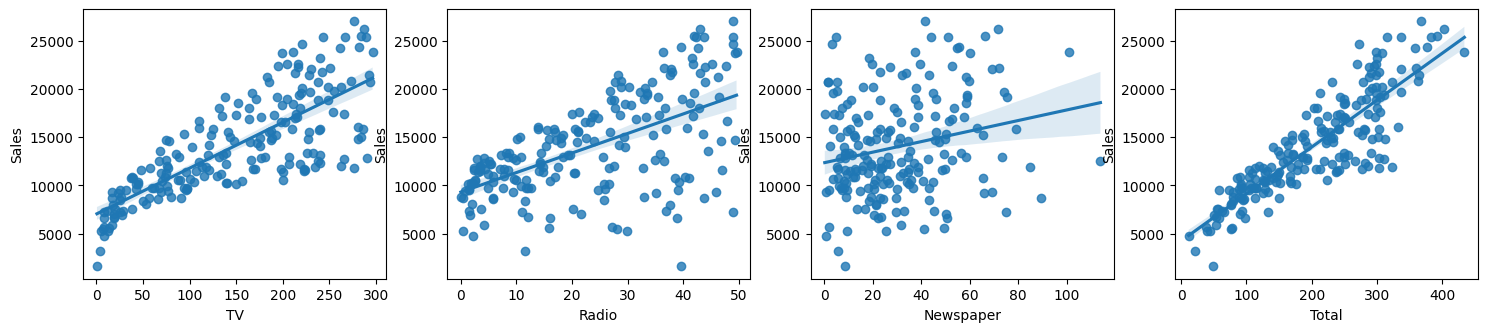

In [8]:
xs = ['TV', 'Radio', 'Newspaper', 'Total']

fig1, axs1 = plt.subplots(1,4)
fig1.set_size_inches(18, 3.5)

for xi, axi in zip(xs, axs1):
    sns.regplot(data=total_frame, x=xi, y="Sales", ax=axi)
fig1.show()

The figure below illustrates the sales distribution and shows a skewness value of 0.408. This value falls within the range of [-1, 1], which is ideal for proceeding with the analysis, as it indicates that the sales distribution is approximately normally distributed.

Text(0.5, 1.0, 'Skewness: 0.408')

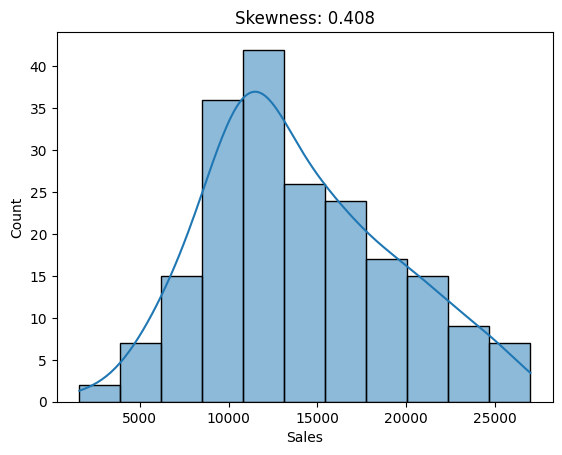

In [9]:
fig2, ax2 = plt.subplots(1,1)

sk = data['Sales'].skew()
sns.histplot(data=data, x='Sales', kde=True, ax=ax2)
ax2.set_title(f'Skewness: {sk:.3f}')

The correlation analysis of the variables is shown below. The final row indicates that TV and Radio are the two advertising channels with the greatest impact on sales. However, to explore more intricate interactions, the data will be modeled using a linear regression model to examine how sales revenue is influenced by budget allocation across each advertising channel.

<Axes: >

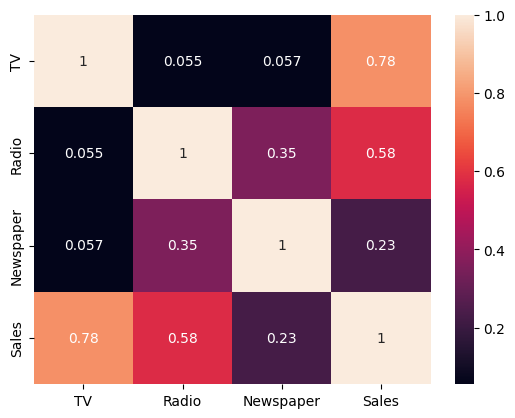

In [10]:
sns.heatmap(data[['TV', 'Radio', 'Newspaper', 'Sales']].corr(), annot=True)

The evidence shown in this analysis suggests that the data analyzed are ideal to be modeled using a linear model, since there is evidence of individual linear relationships between independent and dependent variables, and the total column, resulting from the linear combination of variables, also presents a clear linear dependence. Moreover, the dependant variable (Sales) is aproximatelly normally distributed.

## 2. Model design and validation
First, the data of the independent variables (X) and dependent variable (y) are identified. Moreover, a split of the data is performed, dividing information into two subsets: training and testing.

In [11]:
from sklearn.model_selection import train_test_split

# extract target variable
Xs = data.drop(['Sales'], axis=1).values
ys = data['Sales'].values

# data split
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.20, random_state=0)
X_train.shape, X_test.shape

((160, 3), (40, 3))

Normalization is used to prevent the model from being biased due to the magnitude of each attribute. The `StandardScaler` class normalize variables by performing the following transformtaion:

$$norm(x_i) = \frac{x_i-\mu(X)}{\sigma(X)}$$

where $\mu(X)$ and $\sigma(X)$ are the mean and standard deviation of $X$, respectively.

In [12]:
from sklearn.preprocessing import StandardScaler

# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

print(f'Standar variables: {X_train[0]}')
print(f'Scaled variables: {scaler.transform([X_train[0]])[0]}') # transformation

Standar variables: [36.9 38.6 65.6]
Scaled variables: [-1.34155345  1.0355176   1.65941078]


Two models are trained on the training set: a linear regression model and a Support Vector Regressor (SVR), using a linear kernel. Both models use the same standard scaler before evaluating the model.

In [13]:
# linear regression training
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

# linear regression
model_LR = make_pipeline(StandardScaler(), LinearRegression())
model_LR.fit(X_train, y_train)

# SVR
model_SVR = make_pipeline(StandardScaler(), SVR(C=100.0, epsilon=100.0, kernel='linear'))
model_SVR.fit(X_train, y_train)

models = [model_LR, model_SVR]

The evaluation of the performance of each model on the test set is shown below.

- The Linear Regression model has a lower mean square error (MSE) than the SVR.
- Moreover the R2 values ​​indicate that the predictions of the Linear Regression model fit the real values ​​of the dependent variable better than the predictions of the SVR.
- Therefore the Linear REgression model is the best option to continue with the analysis.

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# performance metrics
mses = []
r2s = []
for mi in models:
    preds = mi.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mses.append(mse)
    r2s.append(r2)

# resultados
labels = ['Linear Regression', 'SVR (Linear)']
results = pd.DataFrame({'Modelos':labels,
                        'MSE': mses,
                        'R2': r2s})
results

,Modelos,MSE,R2
0,Linear Regression,4.402118e+06,0.860115
1,SVR (Linear),5.556461e+06,0.823433


## 3. Experiments with differente strategies
Different strategies are tested to evaluate the impact of different budget allocations on each advertising channel. The strategies to be evaluated are shown below:
1. Priority on TV (70% TV, 15% Radio, 15% Newspaper), similar to the average current distribution of budget.
2. Priority on Radio (15% TV, 70% Radio, 15% Newspaper).
3. Priority on Newspaper (15% TV, 15% Radio, 70% Newspaper).
4. Equal distribution (33.3% TV, 33.3% Radio, 33.3% Newspaper).

This strategies are tested below, with diferent budgets. The following plot shows the predicted profit, which is calculated considering the predicted sales revenue profit minus the advertising investment:
$$profit = 0.25*\text{predidtec sales}-\text{advertising investment}$$

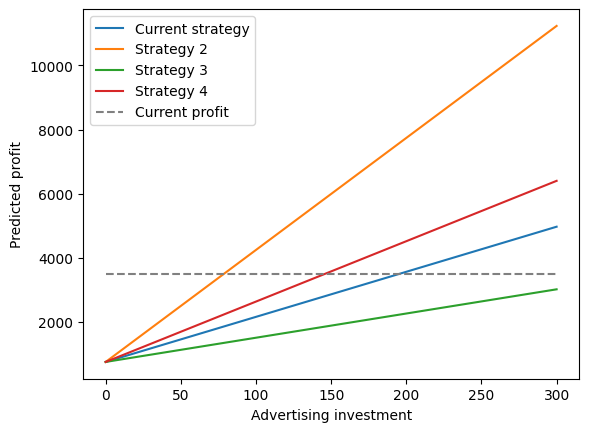

In [ ]:
# distribution strategies
strats = np.array([[0.7, 0.15, 0.15],
          [0.15, 0.7, 0.15],
          [0.15, 0.15, 0.7],
          [0.333, 0.333, 0.333]])

# fig and ax plots
fig3, ax3 = plt.subplots(1,1)
labels = ['Current strategy', 'Strategy 2', 'Strategy 3', 'Strategy 4']

for i, si in enumerate(strats):
    # total budget options 0-300
    budgets = np.arange(0, 301, 10)
    distributions = []
    for bi in budgets:
        di = np.array([bi]*3)
        distributions.append(si*bi)
    distributions = np.array(distributions)

    # model sales predictions
    preds = model_LR.predict(distributions)

    # calculation of actual profit
    profit = preds*0.25-budgets

    # plot predictions
    ax3.plot(budgets, profit, label=labels[i])

# plot current profit
ax3.plot(budgets, [3505]*len(budgets), label='Current profit', linestyle='dashed', color='gray')
ax3.legend()
ax3.set_xlabel('Advertising investment')
ax3.set_ylabel('Predicted profit')

plt.show()


It is observed that Strategy 2, which prioritizes the Radio channel, manages to exceed the current profit with an investment of around $80,000, while in the current strategy this profit is achieved with an investment of approximately $200,000.

Additionally, investing $200 in Strategy 2 is projected to yield a profit of $7,739,638, indicating a 2.17 times increase over the $3,562,030 profit from the current strategy with the same investment, effectively doubling the profits.

In [ ]:
# predicted profict with the current strategy and Strategy 2
current_budget = [200*0.70, 200*0.15, 200*0.15]
budget2 = [200*0.15, 200*0.70, 200*0.15]
sales_revenue = model_LR.predict([current_budget, budget2])
profit = sales_revenue*0.25-200

array([3562.03073812, 7739.6386241 ])

## 4. Conclussions
- Although the current strategy produces good profit margins, this strategy can still be optimized by studying the data.
- Strategy 2 achieves double profits by prioritizing investment in the Radio channel, unlike the current strategy that prioritizes investment in the TV channel.
- This is possibly because it is cheaper to buy advertising on the Radio channel, or because this channel is aimed at a more suitable audience for the products for sale.